<a href="https://colab.research.google.com/github/alice202122/Thesis/blob/main/POSTseg_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from IPython.display import Image, display
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
import cv2 #image operations

In [3]:
import pickle
import os
import random
import pandas as pd
import seaborn as sns
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from PIL import Image

from tensorflow.keras import layers, models, backend, applications, regularizers, initializers
from tensorflow.keras.layers import Layer

from tensorflow.python.ops import math_ops

from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from sklearn.utils import class_weight
from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, GlobalAveragePooling1D,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.8.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [27]:
%cd /content/drive/MyDrive/Tesi

/content/drive/MyDrive/Tesi


In [29]:
 !unzip Post_seg_BINARY.zip

Archive:  Post_seg_BINARY.zip
   creating: Post_seg_BINARY/TEST/
   creating: Post_seg_BINARY/TEST/Healthy_comb/
  inflating: Post_seg_BINARY/TEST/Healthy_comb/1505_Intini_Anna Maria_520_Angio Retina_OD_2016-12-22_12-01-29_F_1947-06-05.tif  
  inflating: Post_seg_BINARY/TEST/Healthy_comb/1505_Intini_Anna Maria_520_Angio Retina_OS_2016-12-22_12-05-55_F_1947-06-05.tif  
  inflating: Post_seg_BINARY/TEST/Healthy_comb/1508_Plini_Giuseppe Giovanni_530_Angio Retina_OD_2017-01-19_11-02-12_M_1947-10-11.tif  
  inflating: Post_seg_BINARY/TEST/Healthy_comb/1508_Plini_Giuseppe Giovanni_530_Angio Retina_OS_2017-01-19_11-06-12_M_1947-10-11.tif  
  inflating: Post_seg_BINARY/TEST/Healthy_comb/1509_Marzano_Giovanna_528_Angio Retina_OD_2017-01-19_10-30-06_F_1950-04-11.tif  
  inflating: Post_seg_BINARY/TEST/Healthy_comb/1509_Marzano_Giovanna_528_Angio Retina_OS_2017-01-19_10-36-48_F_1950-04-11.tif  
  inflating: Post_seg_BINARY/TEST/Healthy_comb/1513_insalata_teresa_543_Angio Retina_OD_2017-01-26_12-0

##directories joining

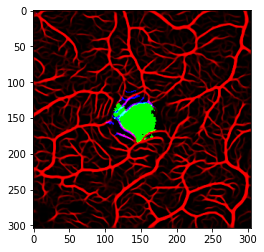

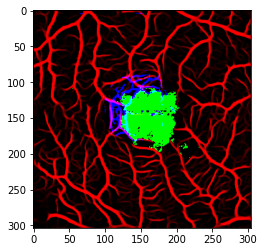

In [7]:
DATADIR = "/content/drive/MyDrive/Tesi/Post_seg_BINARY"
FOLDERS= ['TRAIN', 'VALIDATION', 'TEST']
CATEGORIES=['Healthy_comb', 'Unhealthy_comb']

for folder in FOLDERS:
    path = os.path.join(DATADIR, folder)
    for category in CATEGORIES:
      img_path= os.path.join(path, category)
      for img in os.listdir(img_path):
        img_array = cv2.imread(os.path.join(img_path,img), cv2.COLOR_BGR2RGB)
        plt.imshow(img_array)
        #plt.imshow(img_array[:,:,0])
        plt.show()
        break
    break
    break

        

#Main starting point

In [30]:
dataset_dir = 'Post_seg_BINARY' #path to the folder
training_dir = 'Post_seg_BINARY/TRAIN' #we are putting together these string
validation_dir ='Post_seg_BINARY/VALIDATION'
test_dir = 'Post_seg_BINARY/TEST'


##image data generator

In [31]:
from collections import Counter  
from keras.applications.vgg19 import VGG19

from keras.applications.vgg19 import preprocess_input, decode_predictions
im_gen= ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = im_gen.flow_from_directory(training_dir, 
                                      target_size=(304, 304),
                                      color_mode='rgb', 
                                      class_mode= 'categorical',   
                                      
                                    
                                      shuffle=True,
                                      seed=seed,)
counter = Counter(train_data.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

val_data = im_gen.flow_from_directory(validation_dir, 
                                      target_size=(304, 304),
                                      color_mode='rgb',    
                                      class_mode= 'categorical',   
                                      
                                      shuffle=True,
                                      seed=seed,)
test_data = im_gen.flow_from_directory(test_dir, 
                                      target_size=(304,304),
                                      color_mode='rgb',    
                                      class_mode= 'categorical', 
                                                                
                                      
                                      
                                      shuffle=False,
                                      seed=seed,)

aug_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
    
    rotation_range=5,horizontal_flip=True,)

aug_train_data = aug_img_gen.flow_from_directory(training_dir,
                                                 target_size=(304, 304),
                                                  color_mode='rgb',    
                                                  class_mode= 'categorical',   
                                                  batch_size=32,
                                                  shuffle=True,
                                                  seed=seed,)
images, labels = next(aug_train_data)

print(images.shape)
print(labels.shape)
print(class_weights)

Found 432 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Found 134 images belonging to 2 classes.
Found 432 images belonging to 2 classes.
(32, 304, 304, 3)
(32, 2)
{0: 1.0669856459330143, 1: 1.0}


In [80]:
#true test labels
y_true = test_data.classes
y_training_true= train_data.classes
y_validation_true= val_data.classes

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1], dtype=int32)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [ layers.RandomRotation(0.01),]
)

In [32]:
input_shape= (304,304,3)

In [84]:
#this is a basic model to see the initial scores, without TL and FT
def build_model(input_shape):

    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    #input_layer= data_augmentation(inputs)

    #resize_layer = tfkl.Resizing(224, 224, interpolation="bicubic")(input_layer)

    conv1 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        
       
        name = 'Conv1')(input_layer)
    batch_norm= tfkl.BatchNormalization()(conv1)
    act1= keras.layers.LeakyReLU(alpha=0.2)(batch_norm)
    pool1 = tfkl.MaxPooling2D(name = 'Pool1')(act1)

    conv2 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
       
        
        name = 'Conv2')(act1)
    act2= keras.layers.LeakyReLU(alpha=0.2)(conv2)
    pool2 = tfkl.MaxPooling2D(name = 'Pool2')(act2)
    
    conv3 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        
        
        name = 'Conv3')(pool2)
    act3= keras.layers.LeakyReLU(alpha=0.2)(conv3)
    pool3 = tfkl.MaxPooling2D(name = 'Pool3')(act3)

    
    conv4 = tfkl.Conv2D(
        filters=256,
        kernel_size=(2, 2),
        strides = (1, 1),
        padding = 'same',
        
        
        name = 'Conv4')(pool3)
    act4= keras.layers.LeakyReLU(alpha=0.2)(conv4)
    pool4 = tfkl.MaxPooling2D(name = 'Pool4')(act4)
    conv5 = tfkl.Conv2D(
        filters=1024,
        kernel_size=(2, 2),
        strides = (1, 1),
        padding = 'same',
        
        
        name = 'Conv5')(pool4)
    act5= keras.layers.LeakyReLU(alpha=0.2)(conv5)
    
    batch_norm2= tfkl.BatchNormalization()(act5)
    
    
    glob_pooling = tfkl.GlobalAveragePooling2D(name='GlobalPooling')(batch_norm2)
    
    
    classifier_layer = tfkl.Dropout(0.3, seed=seed, name='ClassifierDropout')(glob_pooling)

  
    
    output_layer = tfkl.Dense(
       units=2, 
       kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),activation= 'sigmoid',
     name='Output')(classifier_layer)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(), f1_m,precision_m, recall_m],)

    # Return the model
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 304, 304, 3)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 304, 304, 32)      2432      
                                                                 
 batch_normalization_21 (Bat  (None, 304, 304, 32)     128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 304, 304, 32)      0         
                                                                 
 Conv2 (Conv2D)              (None, 304, 304, 64)      51264     
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 304, 304, 64)      0         
                                                             

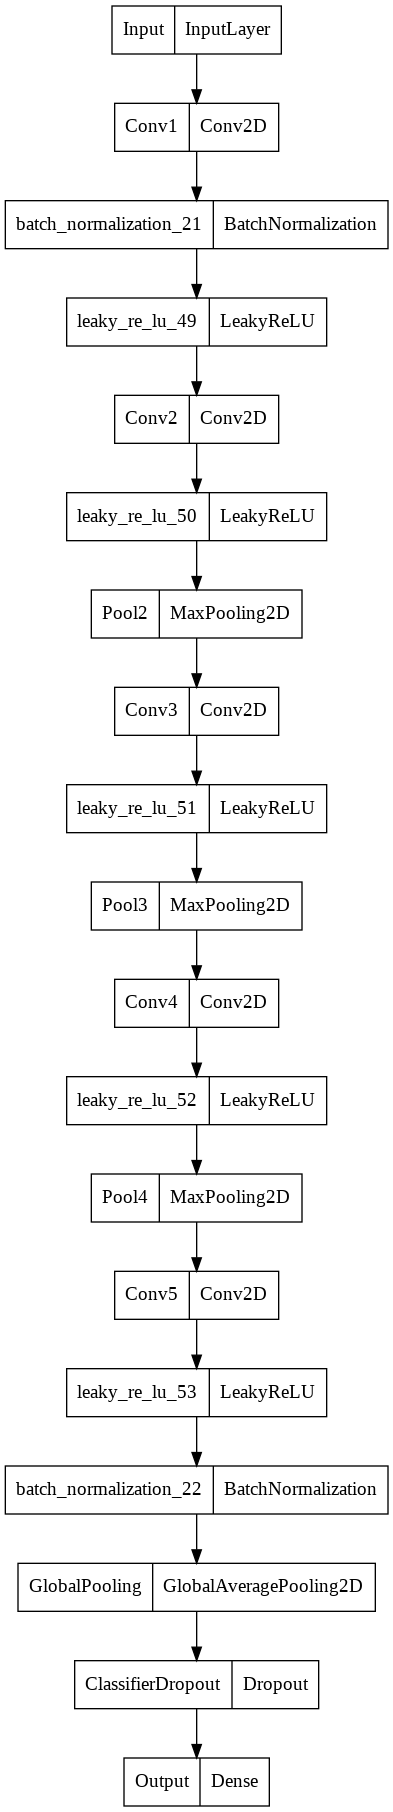

In [70]:
standard_model = build_model(input_shape)
standard_model.summary()




In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [85]:
# Train the model
standard_history = standard_model.fit(
    aug_train_data, 
    batch_size = 16,
    epochs = 50,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=10, restore_best_weights=True),
                   tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)]
).history

Epoch 1/50
14/14 [==============================] - 13s 936ms/step - loss: 0.6212 - binary_accuracy: 0.6250 - val_loss: 0.8589 - val_binary_accuracy: 0.5395 - lr: 3.1250e-05
Epoch 2/50
14/14 [==============================] - 12s 819ms/step - loss: 0.6278 - binary_accuracy: 0.6354 - val_loss: 0.8462 - val_binary_accuracy: 0.5439 - lr: 3.1250e-05
Epoch 3/50
14/14 [==============================] - 12s 826ms/step - loss: 0.6265 - binary_accuracy: 0.6389 - val_loss: 0.8256 - val_binary_accuracy: 0.5439 - lr: 3.1250e-05
Epoch 4/50
14/14 [==============================] - 12s 813ms/step - loss: 0.6186 - binary_accuracy: 0.6447 - val_loss: 0.8228 - val_binary_accuracy: 0.5439 - lr: 3.1250e-05
Epoch 5/50
14/14 [==============================] - 12s 858ms/step - loss: 0.6260 - binary_accuracy: 0.6331 - val_loss: 0.8549 - val_binary_accuracy: 0.5351 - lr: 3.1250e-05
Epoch 6/50
14/14 [==============================] - 12s 850ms/step - loss: 0.6327 - binary_accuracy: 0.6539 - val_loss: 0.8142 - v

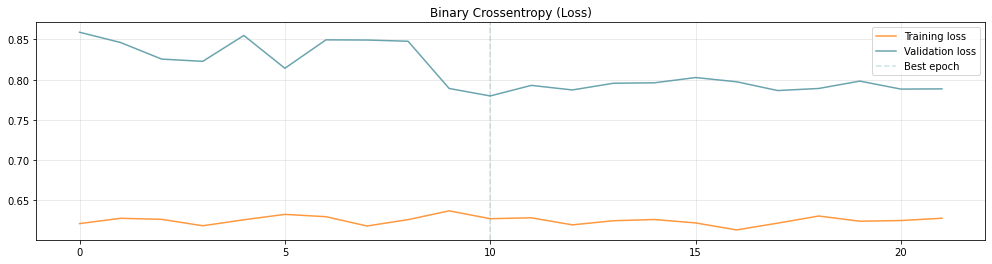

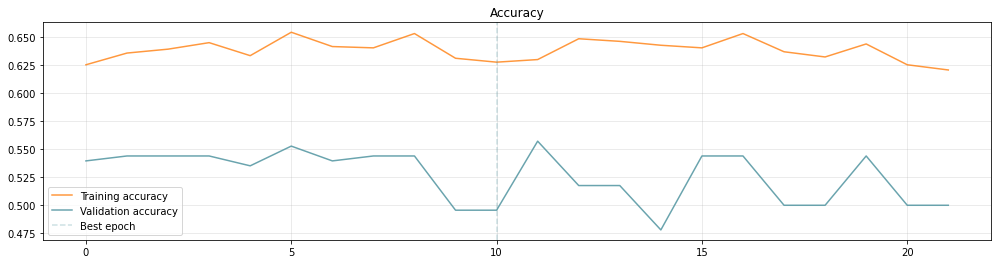

In [86]:
best_epoch = np.argmin(standard_history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(standard_history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(standard_history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Binary Crossentropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(standard_history['binary_accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(standard_history['val_binary_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()



In [77]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = standard_model.evaluate(test_data)

5/5 [==============================] - 1s 144ms/step - loss: 0.7400 - binary_accuracy: 0.5858


ValueError: ignored

In [87]:
pred = standard_model.predict(test_data)
y_pred = np.argmax(pred,axis=1) 

In [91]:
y_pred_bool

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1])

In [90]:
from sklearn.metrics import classification_report
#support is the number of actual occurrences in the test set of those classes

y_pred = standard_model.predict(test_data, batch_size=16, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_bool))
#DEMENTIA PATIENTS NEVER PREDICTED

5/5 [==============================] - 1s 171ms/step
              precision    recall  f1-score   support

           0       0.74      0.22      0.33        65
           1       0.56      0.93      0.70        69

    accuracy                           0.58       134
   macro avg       0.65      0.57      0.51       134
weighted avg       0.64      0.58      0.52       134



In [32]:
y_pred_standard = standard_model.predict(test_data, batch_size=16, verbose=1)
y_pred_bool_standard = np.argmax(y_pred_standard, axis=1)

5/5 [==============================] - 2s 459ms/step


In [33]:
y_pred_bool_standard

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1])

In [34]:
from sklearn.metrics import classification_report

y_pred = standard_model.predict(test_data, batch_size=32, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_bool))

5/5 [==============================] - 1s 146ms/step
              precision    recall  f1-score   support

           0       0.50      0.16      0.24        69
           1       0.56      0.87      0.68        86

    accuracy                           0.55       155
   macro avg       0.53      0.52      0.46       155
weighted avg       0.54      0.55      0.49       155



##TRANFER LEARNING

In [47]:
input_shape= (304,304,3)
batch_size =  8

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

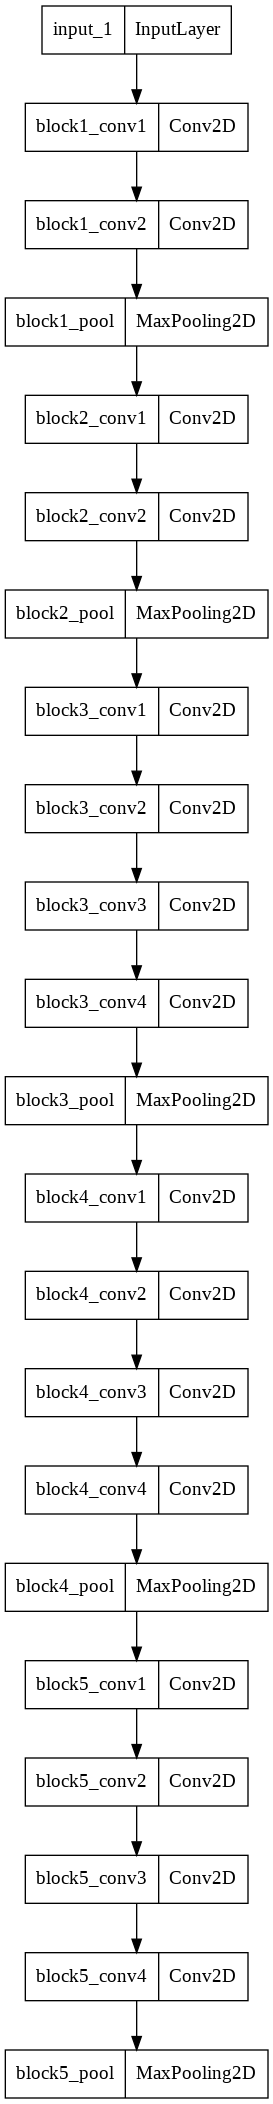

In [48]:
supernet = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [49]:
# Use the supernet as feature extractor
supernet.trainable = False
initializer = tf.keras.initializers.HeNormal()
values = initializer(shape=(2, 2))

inputs = tfk.Input(shape=(304,304,3))
x = tfkl.Resizing(224, 224, interpolation="bicubic")(inputs)
#x= data_augmentation(x)
x = supernet(x)
#tried to insert a conv layer here, but even with only 8 units it makes the model overfit
#x= keras.layers.Conv2D(16, (3,3))(x)
x= keras.layers.LeakyReLU(alpha=0.2)(x)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dropout(0.4)(x)  # Regularize with dropout
outputs = keras.layers.Dense(2, kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-3),
    bias_regularizer=regularizers.L2(1e-4),
    activity_regularizer=regularizers.L2(1e-4), kernel_initializer=initializer,activation= 'sigmoid')(x)

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
sgd = SGD(learning_rate=0.0001,  momentum=0.9, nesterov=True) #using SGD as optimizer since with adam accuracy got stucked
#tf.keras.optimizers.Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad")
#tf.keras.optimizers.Adam( learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07, amsgrad=False, name='Adam')
#tf.keras.optimizers.Adadelta( learning_rate=0.0001,    rho=0.95,    epsilon=1e-05,    name='Adadelta')
#tf.keras.optimizers.RMSprop(  learning_rate=0.001,  rho=0.9,  momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')

tl_model.compile(
    optimizer=sgd,
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy()],)
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [50]:
# Train the model
tl_history = tl_model.fit(
    aug_train_data,
    batch_size = batch_size,
    epochs = 40,
    class_weight= class_weights,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max', patience=10, restore_best_weights=True),  
                 tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)]
).history

Epoch 1/40
14/14 [==============================] - 15s 823ms/step - loss: 6.3656 - binary_accuracy: 0.5150 - val_loss: 1.3503 - val_binary_accuracy: 0.5175 - lr: 1.0000e-04
Epoch 2/40
14/14 [==============================] - 11s 748ms/step - loss: 3.0208 - binary_accuracy: 0.5278 - val_loss: 1.7040 - val_binary_accuracy: 0.4649 - lr: 1.0000e-04
Epoch 3/40
14/14 [==============================] - 10s 740ms/step - loss: 2.3106 - binary_accuracy: 0.5208 - val_loss: 1.2569 - val_binary_accuracy: 0.5307 - lr: 1.0000e-04
Epoch 4/40
14/14 [==============================] - 10s 742ms/step - loss: 2.0997 - binary_accuracy: 0.5208 - val_loss: 1.1909 - val_binary_accuracy: 0.5175 - lr: 1.0000e-04
Epoch 5/40
14/14 [==============================] - 10s 730ms/step - loss: 1.7861 - binary_accuracy: 0.5475 - val_loss: 1.2937 - val_binary_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/40
14/14 [==============================] - 10s 726ms/step - loss: 1.8151 - binary_accuracy: 0.5197 - val_loss: 1.2840 - v

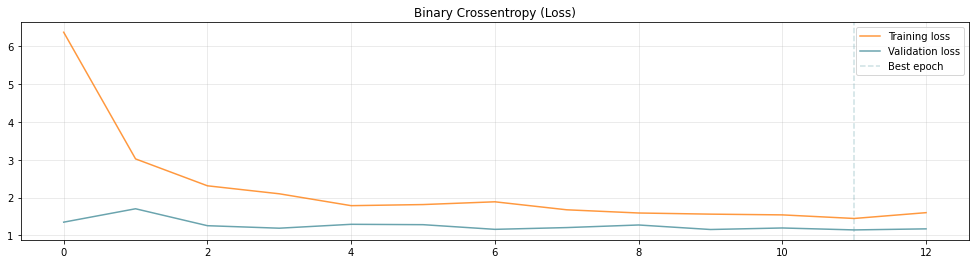

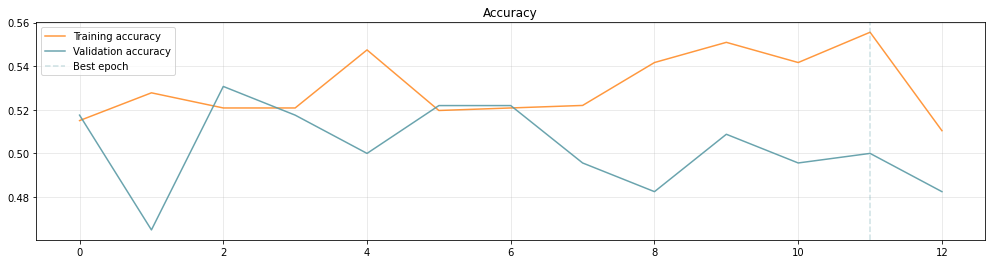

In [51]:
best_epoch = np.argmin(tl_history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(tl_history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Binary Crossentropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(tl_history['binary_accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['val_binary_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()



In [52]:
# Save the best model
tl_model.save('TransferLearningModel1')

INFO:tensorflow:Assets written to: TransferLearningModel1/assets


##FINE TUNING

In [53]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel1')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 leaky_re_lu_43 (LeakyReLU)  (None, 7, 7, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [54]:
# Set all SUPERNET layers to True
ft_model.get_layer('vgg19').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [55]:
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(ft_model.get_layer('vgg19').layers[:16]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg19').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 False
11 block3_pool False
12 block4_conv1 False
13 block4_conv2 False
14 block4_conv3 False
15 block4_conv4 False
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 304, 304, 3)]     0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 

In [56]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




In [57]:
# Compile the model
sgd = SGD(learning_rate=0.0001,  momentum=0.9, nesterov=True)
#tf.keras.optimizers.Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad")
#tf.keras.optimizers.Adam( learning_rate=0.00001,beta_1=0.9,beta_2=0.999,epsilon=1e-05, amsgrad=False, name='Adam')
#tf.keras.optimizers.Adadelta( learning_rate=0.0001,    rho=0.95,    epsilon=1e-07,    name='Adadelta')
#tf.keras.optimizers.RMSprop(  learning_rate=0.0001,  rho=0.9,  momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=sgd, metrics=['accuracy',f1_m,precision_m, recall_m])

In [58]:
# Fine-tune the model
ft_history = ft_model.fit(
   train_data,
    
    epochs = 40,
    class_weight= class_weights,
    validation_data = val_data,
    callbacks = [tfk.callbacks.EarlyStopping(monitor= 'val_loss', mode='max', patience=10, restore_best_weights=True),
                  tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)]
).history #here I monitor validation loss to monitor overfitting

Epoch 1/40
14/14 [==============================] - 6s 342ms/step - loss: 1.3554 - accuracy: 0.5417 - f1_m: 0.5110 - precision_m: 0.5211 - recall_m: 0.5089 - val_loss: 0.7515 - val_accuracy: 0.4561 - val_f1_m: 0.4316 - val_precision_m: 0.4643 - val_recall_m: 0.4062 - lr: 1.0000e-04
Epoch 2/40
14/14 [==============================] - 4s 304ms/step - loss: 0.7319 - accuracy: 0.5417 - f1_m: 0.5328 - precision_m: 0.5424 - recall_m: 0.5290 - val_loss: 0.7126 - val_accuracy: 0.4386 - val_f1_m: 0.4936 - val_precision_m: 0.4829 - val_recall_m: 0.5061 - lr: 1.0000e-04
Epoch 3/40
14/14 [==============================] - 4s 295ms/step - loss: 0.7002 - accuracy: 0.5718 - f1_m: 0.5843 - precision_m: 0.5600 - recall_m: 0.6138 - val_loss: 0.7194 - val_accuracy: 0.4211 - val_f1_m: 0.5229 - val_precision_m: 0.4939 - val_recall_m: 0.5573 - lr: 1.0000e-04
Epoch 4/40
14/14 [==============================] - 4s 303ms/step - loss: 0.6768 - accuracy: 0.6412 - f1_m: 0.6514 - precision_m: 0.6218 - recall_m: 0.

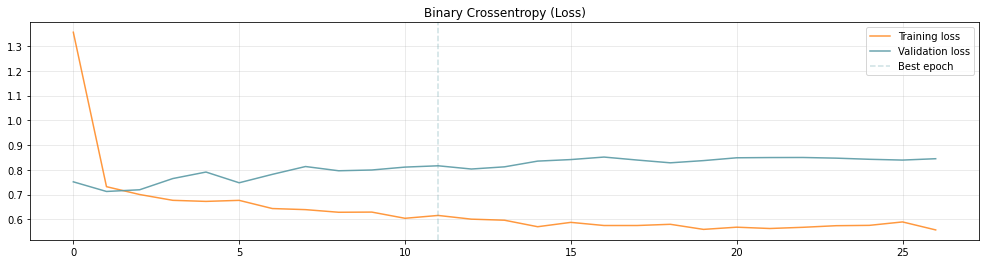

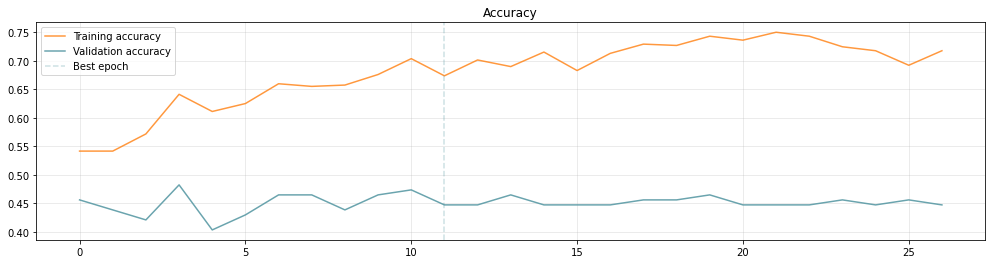

In [59]:
best_epoch = np.argmin(tl_history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(ft_history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(ft_history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Binary Crossentropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(ft_history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(ft_history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [60]:
# evaluate the model
loss, accuracy, f1_score, precision, recall = ft_model.evaluate(test_data)

5/5 [==============================] - 2s 410ms/step - loss: 0.7217 - accuracy: 0.5597 - f1_m: 0.5362 - precision_m: 0.5251 - recall_m: 0.5479


In [61]:
pred = ft_model.predict(test_data)
y_pred = np.argmax(pred,axis=1) 

In [64]:
y_true

NameError: ignored

In [63]:
y_pred

array([[0.6034369 , 0.6590981 ],
       [0.6251093 , 0.3656144 ],
       [0.45865142, 0.6542047 ],
       [0.48390442, 0.5350901 ],
       [0.48314506, 0.46899188],
       [0.58076525, 0.5773422 ],
       [0.60121626, 0.35842198],
       [0.7996535 , 0.3069287 ],
       [0.49459183, 0.44996676],
       [0.65212864, 0.44195777],
       [0.59136295, 0.4427853 ],
       [0.61530554, 0.3764103 ],
       [0.64114046, 0.42102617],
       [0.54783386, 0.50443166],
       [0.8619781 , 0.32116672],
       [0.56803244, 0.24276206],
       [0.69087255, 0.34762505],
       [0.61875254, 0.31191507],
       [0.5219261 , 0.46670204],
       [0.5913157 , 0.3024734 ],
       [0.7249815 , 0.31434137],
       [0.75948685, 0.19919078],
       [0.7192279 , 0.33896163],
       [0.65595937, 0.28493708],
       [0.2281994 , 0.77219665],
       [0.34919417, 0.8538809 ],
       [0.46847522, 0.5977907 ],
       [0.52152896, 0.57540774],
       [0.613548  , 0.4393255 ],
       [0.6078319 , 0.36046585],
       [0.

In [62]:
from sklearn.metrics import classification_report
#support is the number of actual occurrences in the test set of those classes

y_pred = ft_model.predict(test_data, batch_size=4, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_bool))
#DEMENTIA PATIENTS NEVER PREDICTED

5/5 [==============================] - 1s 271ms/step


NameError: ignored

#con il fine tuning il modello overfitta.

In [ ]:
import keras.backend as K

In [ ]:
y_pred

array([2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2,
       1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2])

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

##METRICS

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.SensitivityAtSpecificity( 0.5),
     
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#ROC-AUC

0= DEMENTIA: 3.7611940298507465,


1:HEALTHY CONTROL 1.8666666666666667,


2:MILD COGNITIVE IMPAIRMENT *1.0*

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [ ]:
pred = ft_model.predict(test_data)
pred = np.argmax(pred,axis=1) 

In [ ]:
pred

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
from sklearn import metrics

score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))

Accuracy score: 0.5542168674698795


In [ ]:
from IPython.display import display

# Don't display numpy in scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Generate predictions
pred = ft_model.predict(test_data)

print("Numpy array of predictions")
display(pred[0:5])

print("As percent probability")
print(pred[0]*100)

score = metrics.log_loss(y_true, pred)
print("Log loss score: {}".format(score))

# raw probabilities to chosen class (highest probability)
pred = np.argmax(pred,axis=1) 

Numpy array of predictions


array([[0.5002, 0.5028],
       [0.4985, 0.5028],
       [0.4985, 0.5028],
       [0.4999, 0.5028],
       [0.4985, 0.5028]], dtype=float32)

As percent probability
[50.0237 50.2819]
Log loss score: 0.6926974219730101


In [ ]:
prob_vector = ft_model.predict(test_data)[:, 1]

In [ ]:
prob_vector.shape

(144,)

In [ ]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [ ]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

Text(0, 0.5, 'True Positive Rate')

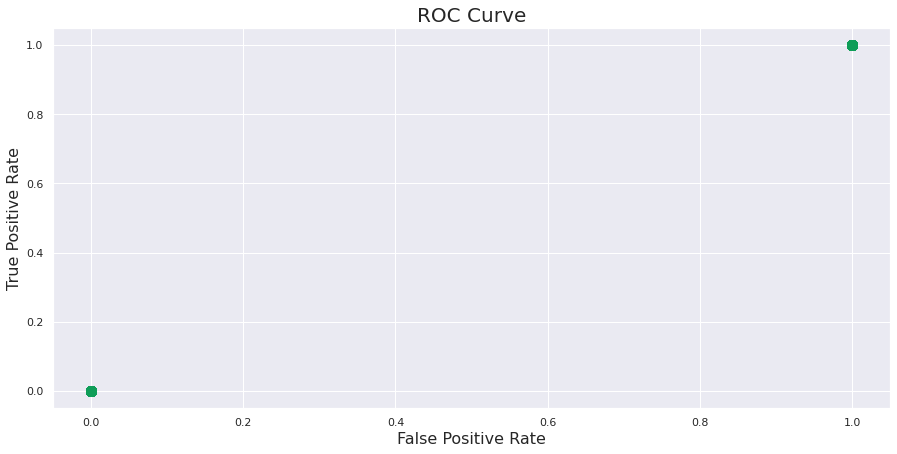

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
plt.figure(figsize=(15,7))

ROC = roc_from_scratch(prob_vector,y_true,partitions=100)
plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)

In [ ]:
def create_triangle(tpr_0,tpr_1,fpr_0,fpr_1):
    plt.plot([tpr_0,tpr_1],[fpr_0,fpr_1], 'k-', lw=2,color='#4285F4')
    plt.plot([tpr_0,tpr_1],[fpr_1,fpr_1], 'k-', lw=2,color='#4285F4')
    plt.plot([tpr_0,tpr_0],[fpr_0,fpr_1], 'k-', lw=2,color='#4285F4')
    print('area: ',(tpr_0-tpr_1)*(fpr_0-fpr_1)/2)

def create_rectangle(tpr_0,fpr_0):
    plt.plot([tpr_0,tpr_0],[fpr_0,0], 'k-', lw=2,color='#4285F4')

In [ ]:
import pandas as pd
import numpy as np
partitions = 100
ROC = roc_from_scratch(prob_vector, y_true, partitions=partitions)
fpr, tpr = ROC[:, 0], ROC[:, 1]
rectangle_roc = 0
for k in range(partitions):
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
rectangle_roc

1.0

##grad cam 

In [ ]:
from tqdm import tqdm
from tensorflow.python.keras.utils.data_utils import Sequence 

In [ ]:
CATEGORIES=['Healthy_comb', 'Unhealthy_comb']
